### RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?
To answer this question, we estimate a **reduced-form Panel VAR(1)** system, focusing on two outcome variables:
* `cc_pol_tax_t`: support for carbon taxes
* `cc_pol_car_t`: support for emissions standards

Each equation includes the **lagged values** of 15 attitudinal and demographic predictors. The model is estimated using **pooled OLS** with **standard errors clustered at the respondent level (`PID`)**, based on 1,722 complete observations across three survey waves.
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Willingness to pay** (lagged):
  `ccSolve`
* **Climate policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car` (to capture cross-policy influence)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographic controls** (lagged):
  `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The following system of two equations is estimated:
$$
\begin{cases}
\text{cc\_pol\_tax}_t = \alpha_1 + \sum_{j=1}^{15} \beta_{1j} \cdot X_{j,t-1} + \epsilon_{1t} \\
\text{cc\_pol\_car}_t = \alpha_2 + \sum_{j=1}^{15} \beta_{2j} \cdot X_{j,t-1} + \epsilon_{2t}
\end{cases}
$$

Where:
- $ X_{j,t-1} $ denotes the value of the $ j $-th predictor at time $ t-1 $  
- $ \alpha_i $ is the intercept for equation $ i $  
- $ \beta_{ij} $ is the coefficient for the effect of predictor $ j $ on outcome $ i $  
- $ \epsilon_{it} $ is the idiosyncratic error term, clustered at the respondent level

In [1]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define continuous/ordinal predictors
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions
for var in continuous_predictors:
    data[f"{var}_lag"] = data.groupby('PID')[var].shift(1)

# Combine all lagged vars
lagged_vars = [f"{var}_lag" for var in continuous_predictors]
all_predictors = lagged_vars

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["cc_pol_tax", "cc_pol_car"])

# --- Model 1: cc_pol_tax_t
X1 = panel_var_data[all_predictors]
y1 = panel_var_data["cc_pol_tax"]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# --- Model 2: cc_pol_car_t
X2 = panel_var_data[all_predictors]
y2 = panel_var_data["cc_pol_car"]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output
print(summary_col(
    [model1, model2],
    stars=True,
    model_names=["cc_pol_tax_t", "cc_pol_car_t"],
    info_dict={"N": lambda x: f"{int(x.nobs)}"}
))


                 cc_pol_tax_t cc_pol_car_t
------------------------------------------
const            0.5381***    0.7163***   
                 (0.1433)     (0.1447)    
cc4_world_lag    0.1848***    0.1513***   
                 (0.0306)     (0.0296)    
cc4_wealthUS_lag -0.0441*     -0.0524**   
                 (0.0250)     (0.0220)    
cc4_poorUS_lag   0.0610**     0.0964***   
                 (0.0301)     (0.0300)    
cc4_comm_lag     -0.0258      0.0062      
                 (0.0366)     (0.0332)    
cc4_famheal_lag  -0.0020      0.0013      
                 (0.0348)     (0.0305)    
cc4_famecon_lag  0.0191       -0.0191     
                 (0.0254)     (0.0229)    
ccSolve_lag      0.0898***    0.0168      
                 (0.0222)     (0.0189)    
cc_pol_tax_lag   0.3437***    0.1039***   
                 (0.0309)     (0.0269)    
cc_pol_car_lag   0.1402***    0.4286***   
                 (0.0296)     (0.0327)    
dem_income_lag   0.0338       0.0242      
          

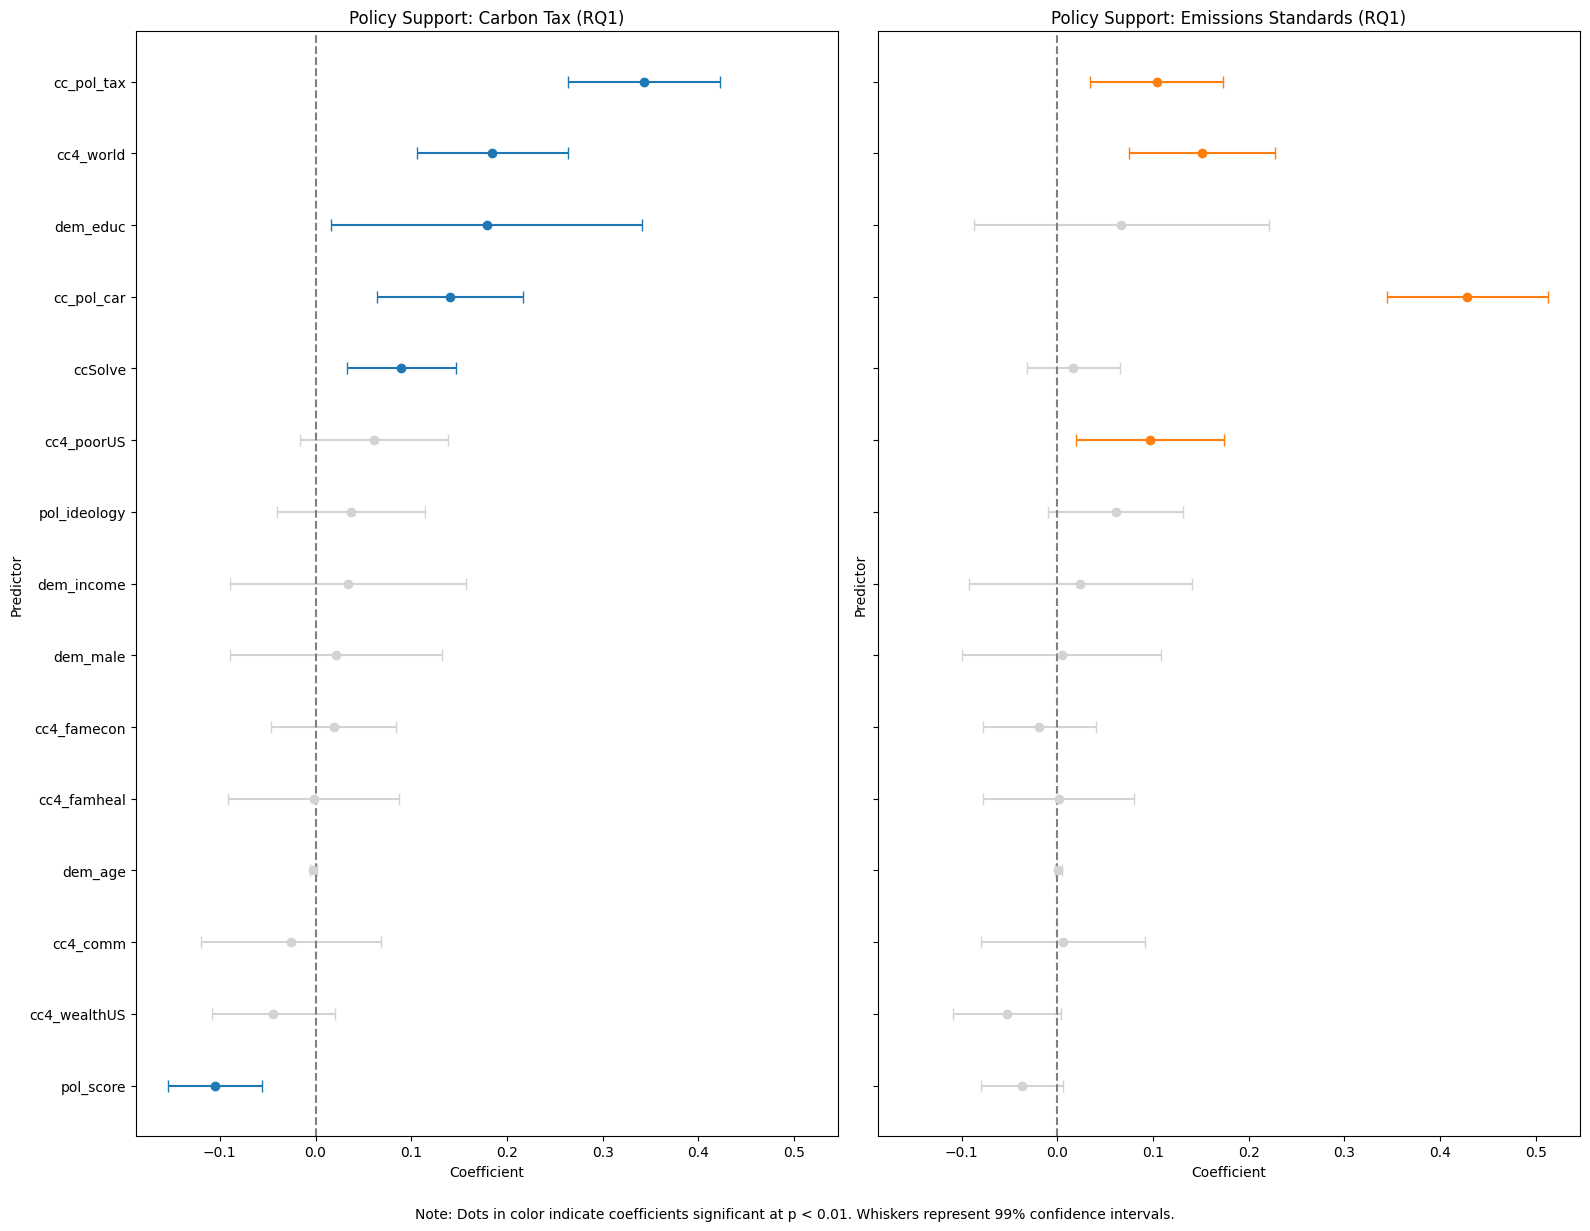

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Get p-values from model
    
    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values,
        'model': label
    }).query("predictor != 'const'")
    
    # Previous threshold: p < 0.05 via 95% CI exclusion of zero
    # df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))

    # New threshold: p < 0.01 via p-value
    df['significant'] = df['pval'] < 0.01

    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    return df.sort_values(by='coef', ascending=True)

# --- Extract separately
df_tax = extract_model_info(model1, "cc_pol_tax_t")
df_car = extract_model_info(model2, "cc_pol_car_t")

# --- Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)

for ax, df, title, color in zip(
    axs,
    [df_tax, df_car],
    ["Policy Support: Carbon Tax (RQ1)", "Policy Support: Emissions Standards (RQ1)"],
    ["tab:blue", "tab:orange"]
):
    for _, row in df.iterrows():
        plot_color = color if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=plot_color,
            ecolor=plot_color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Predictor")

plt.tight_layout()
fig.text(
    0.5, -0.02,
    "Note: Dots in color indicate coefficients significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)
plt.savefig("../results/rq1_dot_whisker_policy_support.png", dpi=300)
plt.show()

> **Note:** Coefficients are sorted by their signed value (not absolute size) to reflect both magnitude (how strong) and direction of effect (positive or negative). Predictors whose 95% confidence intervals include zero (that are not statistically significant) are displayed in gray. This helps focus attention on the variables that clearly have an effect.
> 
> **Why not use absolute coefficients?**  
> Sorting by absolute coefficient size would show the predictors with the strongest effects first, regardless of whether those effects are positive or negative. However, in this analysis, we wanted to highlight **the direction** of each effect (e.g., does it increase or decrease support?). That’s why we sorted by the raw coefficient values - so variables that reduce support appear on one side of the plot, and those that increase it appear on the other.

> **Interpreting a Dot-Whisker Plot**
> A **dot-whisker plot** visualizes the results of regression models by showing each variable’s estimated effect and the uncertainty around it.
> * **Dots** represent **point estimates** (e.g., regression coefficients)
>   * Each dot shows the estimated impact of a predictor variable on the outcome.
> * **Whiskers (horizontal lines)** represent the **confidence intervals** around the estimates
>   * In this plot, we use **99% confidence intervals** (corresponding to **p < 0.01**).
>   * The wider the whisker, the greater the uncertainty in the estimate.
> * A **vertical line at zero** represents **no effect**
>   * If a whisker **crosses zero**, the effect is **not statistically significant** at the 99% level.
>   * If it **does not cross zero**, the effect is considered **statistically significant at p < 0.01**.
>
> This plot helps identify which predictors have **strong, highly significant effects**, and which are more uncertain or weaker. It reflects a stricter approach to significance, focusing only on the most robust relationships.

#### Panel VAR Analysis – RQ1 
*RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?*

The results show that people support carbon taxes and emissions standards more when they believe:
* Climate change harms the world (`cc4_world`)
* Poor people in the U.S. are disproportionately affected (`cc4_poorUS`)

Support is also strongly predicted by prior attitudes: individuals who previously supported either policy are significantly more likely to continue supporting it (`cc_pol_tax`, `cc_pol_car`). This suggests that policy support is **stable over time**, even during an election period.

However, **personal or community-level perceptions of harm** — such as concern about one’s own community or family health — do **not** significantly influence support at the stricter p < 0.01 level.

In the case of **carbon taxes specifically**, two additional factors stand out:
* **Higher education levels** are associated with greater support (`dem_educ`)
* **More conservative political orientation** is associated with lower support (`pol_score`)

These findings suggest that **global concern, fairness, and prior support** are the most robust drivers of climate policy support during elections.

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Combine predictors into one matrix (same for both models) ---
X = panel_var_data[all_predictors]
X = sm.add_constant(X)

# --- Calculate VIF ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Remove constant (optional)
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort and print
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False))

        Variable      VIF                                             Interpretation
    cc4_comm_lag 4.657229 Some correlation (acceptable, but check related variables)
 cc4_famheal_lag 4.222811 Some correlation (acceptable, but check related variables)
  cc4_poorUS_lag 3.940439 Some correlation (acceptable, but check related variables)
   cc4_world_lag 3.600301 Some correlation (acceptable, but check related variables)
 cc4_famecon_lag 2.441409 Some correlation (acceptable, but check related variables)
cc4_wealthUS_lag 2.380742 Some correlation (acceptable, but check related variables)
  cc_pol_car_lag 2.165414 Some correlation (acceptable, but check related variables)
  cc_pol_tax_lag 2.161270 Some correlation (acceptable, but check related variables)
   pol_score_lag 1.988586            Low correlation (no multicollinearity concerns)
pol_ideology_lag 1.940963            Low correlation (no multicollinearity concerns)
  dem_income_lag 1.148649            Low correlation (no multicol

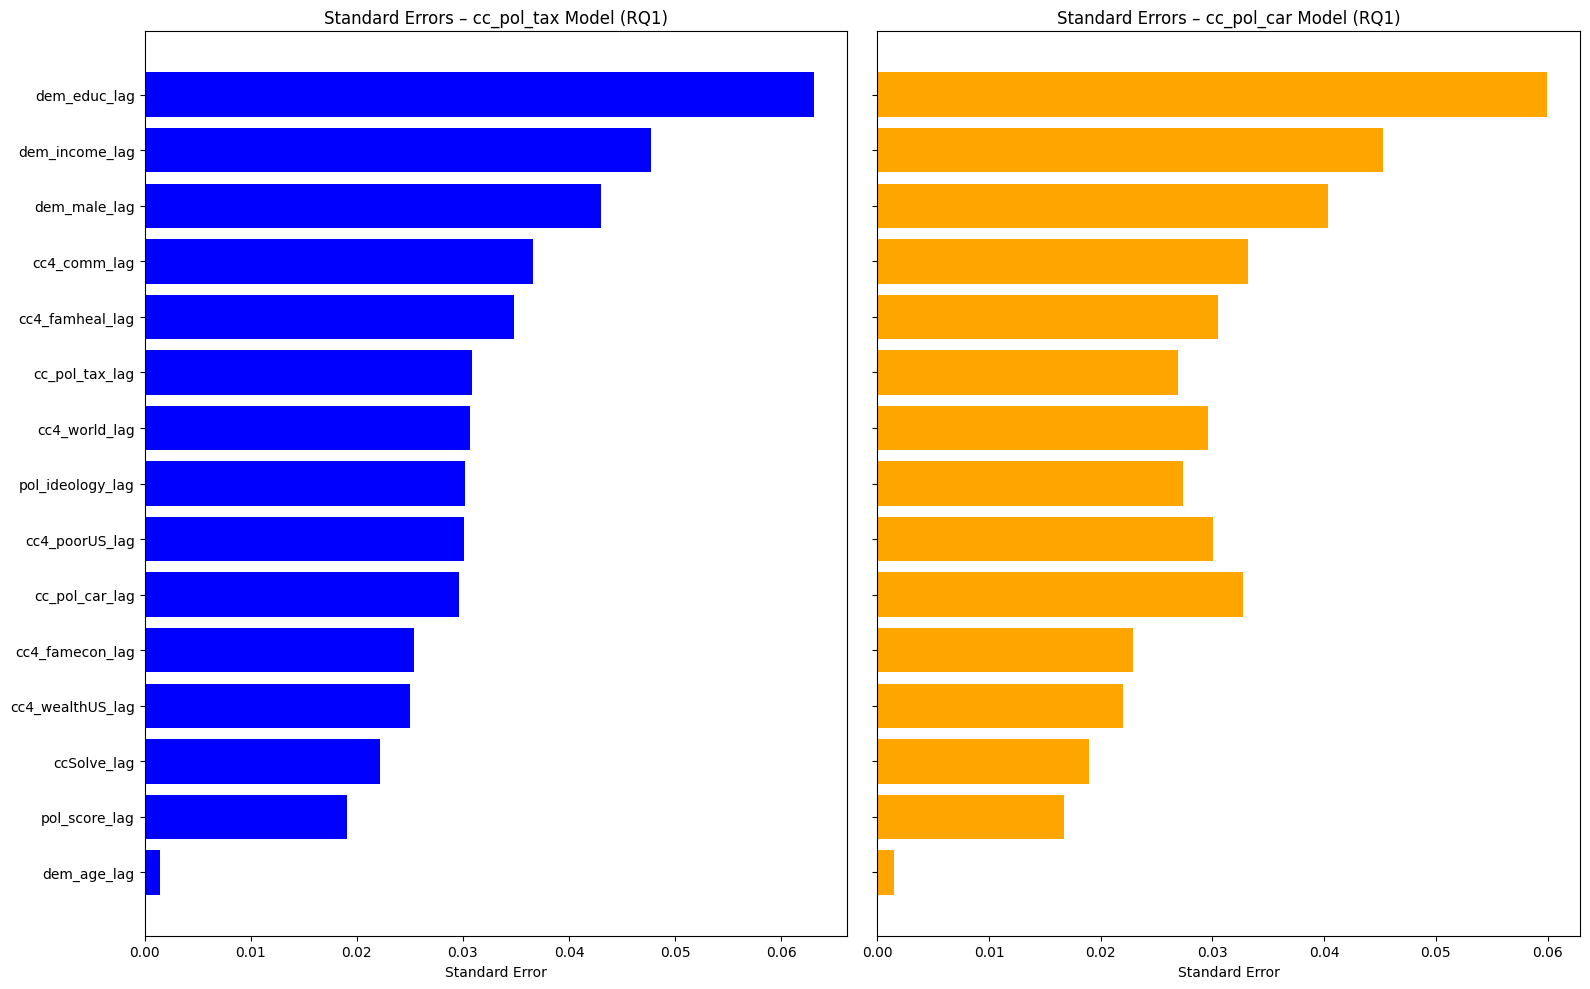

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Create DataFrame for standard error inspection (Model 1: cc_pol_tax) ---
se_model1 = pd.DataFrame({
    'Predictor': model1.params.index,
    'Estimate': model1.params.values,
    'StdError': model1.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Create DataFrame for standard error inspection (Model 2: cc_pol_car) ---
se_model2 = pd.DataFrame({
    'Predictor': model2.params.index,
    'Estimate': model2.params.values,
    'StdError': model2.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Create horizontal subplot layout (side by side)
fig, axes = plt.subplots(ncols=2, figsize=(16, 10), sharey=True)

# Plot for cc_pol_tax model (left)
axes[0].barh(se_model1['Predictor'], se_model1['StdError'], color='blue')
axes[0].set_title('Standard Errors – cc_pol_tax Model (RQ1)')
axes[0].set_xlabel('Standard Error')
axes[0].invert_yaxis()

# Plot for cc_pol_car model (right)
axes[1].barh(se_model2['Predictor'], se_model2['StdError'], color='orange')
axes[1].set_title('Standard Errors – cc_pol_car Model (RQ1)')
axes[1].set_xlabel('Standard Error')

# --- Final layout and save
plt.tight_layout()
plt.savefig("../results/rq1_se_barplot_combined_side_by_side.png", dpi=300)
plt.show()

* The demographic variables `dem_educ_lag`, `dem_income_lag`, and `dem_male_lag` have the **highest standard errors** in both the carbon tax and emissions standards models.
* These high standard errors suggest that these variables contribute the most to **model uncertainty**.
* This aligns with the **wide confidence intervals** (long whiskers) observed for these variables in the dot-whisker plots.
* Although the variables may be **conceptually important**, the model is not confident in their estimated effects.
* Possible reasons for this uncertainty include:
  * **Limited variation** across survey waves,
  * **Collinearity** between demographic predictors (e.g., income and education),
  * **Small subgroup sizes** for certain demographic categories (e.g., by gender or education level).

---

### RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?
To investigate how willingness to financially support climate action evolves over time and whether it shifts during election periods, we estimate a **reduced-form Panel VAR(1)** model with `ccSolve_t` (willingness to pay for climate solutions) as the dependent variable.

The model includes the **lagged values** of 15 time-varying predictors capturing climate harm perceptions, policy attitudes, political identity, and demographic characteristics:
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car`
* **Willingness to pay (lagged)**:
  `ccSolve` (included as its own lag to model temporal dynamics)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographics** (lagged):
  `dem_income`, `dem_age`, `dem_educ`, `dem_male`

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{15} \beta_j \cdot X_{j,t-1} 
+ \epsilon_t
$$

Where:

* $X_{j,t-1}$ denotes the 15 lagged predictors
* $ \alpha $ is the intercept
* $ \epsilon_t $ is the individual-level error term, **clustered by respondent (`PID`)**

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on 1,722 complete observations from three survey waves.

This specification allows us to assess not only which **attitudinal, political, or demographic factors** predict higher or lower willingness to pay for climate action, but also whether the **election period itself exerts a distinct effect**, controlling for prior beliefs and identities.

In [5]:
import statsmodels.api as sm
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variables to be lagged
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions of all predictors
for var in variables:
    data[f'{var}_lag'] = data.groupby('PID')[var].shift(1)

# Final predictors: lagged variables + wave dummy (not lagged)
lagged_vars = [f'{v}_lag' for v in variables]
all_predictors = lagged_vars

# Drop missing values
panel_var_data = data.dropna(subset=all_predictors + ['ccSolve'])

# Estimate the model: ccSolve_t
X = panel_var_data[all_predictors]
y = panel_var_data['ccSolve']
X = sm.add_constant(X)

rq2_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output results
print(rq2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8.969
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.33e-19
Time:                        11:46:57   Log-Likelihood:                -2348.3
No. Observations:                1722   AIC:                             4729.
Df Residuals:                    1706   BIC:                             4816.
Df Model:                          15                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0155      0.154  

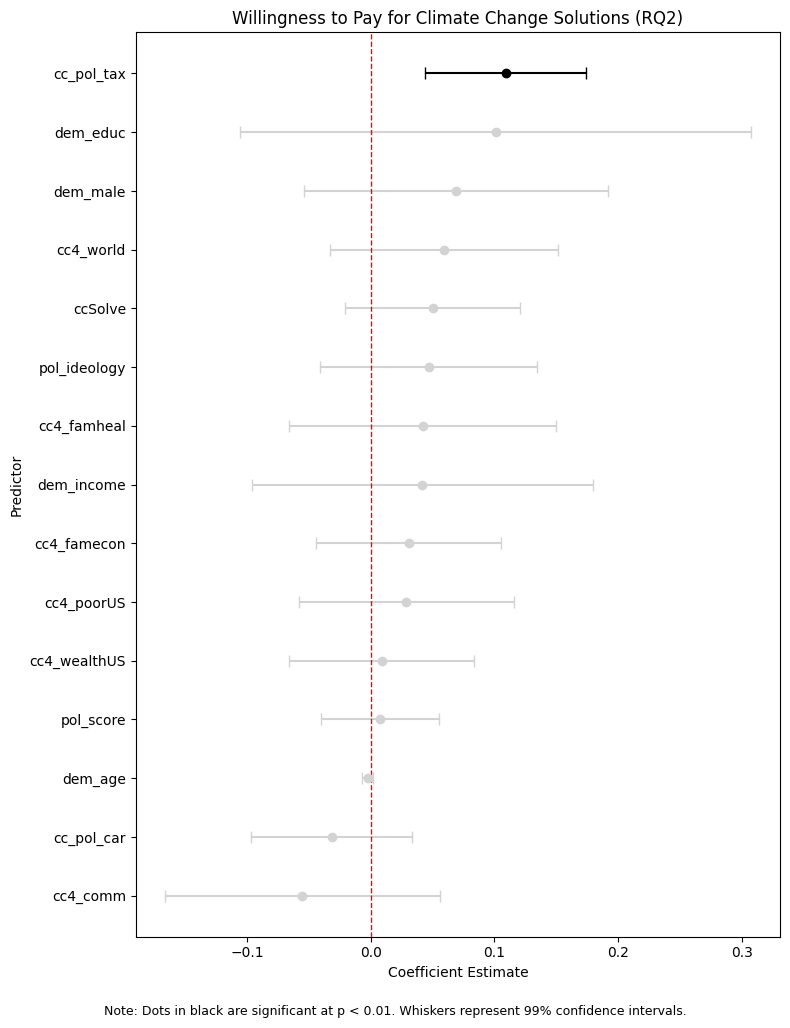

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Step 1: Extract model coefficients and confidence intervals
def extract_model_info(model):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Extract p-values

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")  # exclude intercept

    # --- Previous threshold: p < 0.05 via 95% CI exclusion
    # df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))

    # --- New threshold: p < 0.01
    df['significant'] = df['pval'] < 0.01
    return df

# --- Step 2: Extract info and sort predictors
plot_df = extract_model_info(rq2_model)
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '', regex=False)
plot_df = plot_df.sort_values(by='coef', ascending=True)

# --- Step 3: Plot
plt.figure(figsize=(8, 10))

for _, row in plot_df.iterrows():
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color='black' if row['significant'] else 'lightgray',
        ecolor='black' if row['significant'] else 'lightgray',
        capsize=4
    )

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Willingness to Pay for Climate Change Solutions (RQ2)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor")

# --- Add caption
plt.figtext(
    0.5, -0.02,
    "Note: Dots in black are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=9
)

plt.tight_layout()
plt.savefig("../results/rq2_dot_whisker_ccSolve_coefficients.png", dpi=300)
plt.show()

#### Panel VAR Analysis – RQ2
*RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?*

> **Willingness to pay for climate solutions does not appear to change significantly during elections.**
> 
> Among all the predictors, **only one variable** — **prior support for a carbon tax (`cc_pol_tax`)** — is a **strong and statistically significant predictor** of willingness to pay for climate solutions (`ccSolve`). This suggests that people who already support climate measures are more likely to express financial willingness to contribute to solutions.
> 
> **No other factors**, including perceptions of climate harm to the world, the poor, the wealthy, or one’s community, show statistically significant associations at the stricter p < 0.01 level. Demographics (e.g., age, gender, education, income) and political orientation also do **not** show strong effects in this model.
> 
> **Therefore, the answer to RQ2 is that willingness to pay is stable across the election period** and is **primarily influenced by existing policy support (carbon tax)**.

In [7]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define predictors
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Create lagged versions
data = data.sort_values(by=['PID', 'WAVE'])
for var in variables:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

lagged_vars = [f"{v}_lag" for v in variables]
data = data.dropna(subset=lagged_vars + ['ccSolve'])

# VIF input matrix
X = data[lagged_vars]
X = sm.add_constant(X)

# Compute VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop intercept
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort by VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display the result
print(vif_data.to_string(index=False))

        Variable      VIF                                             Interpretation
    cc4_comm_lag 4.657229 Some correlation (acceptable, but check related variables)
 cc4_famheal_lag 4.222811 Some correlation (acceptable, but check related variables)
  cc4_poorUS_lag 3.940439 Some correlation (acceptable, but check related variables)
   cc4_world_lag 3.600301 Some correlation (acceptable, but check related variables)
 cc4_famecon_lag 2.441409 Some correlation (acceptable, but check related variables)
cc4_wealthUS_lag 2.380742 Some correlation (acceptable, but check related variables)
  cc_pol_car_lag 2.165414 Some correlation (acceptable, but check related variables)
  cc_pol_tax_lag 2.161270 Some correlation (acceptable, but check related variables)
   pol_score_lag 1.988586            Low correlation (no multicollinearity concerns)
pol_ideology_lag 1.940963            Low correlation (no multicollinearity concerns)
  dem_income_lag 1.148649            Low correlation (no multicol

Top variables with largest standard errors in RQ2 (ccSolve model):
       Predictor  Estimate  StdError
    dem_educ_lag  0.100867  0.080173
  dem_income_lag  0.041677  0.053563
    dem_male_lag  0.068670  0.047762
    cc4_comm_lag -0.055449  0.043146
 cc4_famheal_lag  0.041892  0.042018
   cc4_world_lag  0.059011  0.035797
pol_ideology_lag  0.046981  0.034082
  cc4_poorUS_lag  0.028760  0.033839
 cc4_famecon_lag  0.030562  0.029029
cc4_wealthUS_lag  0.008698  0.028997


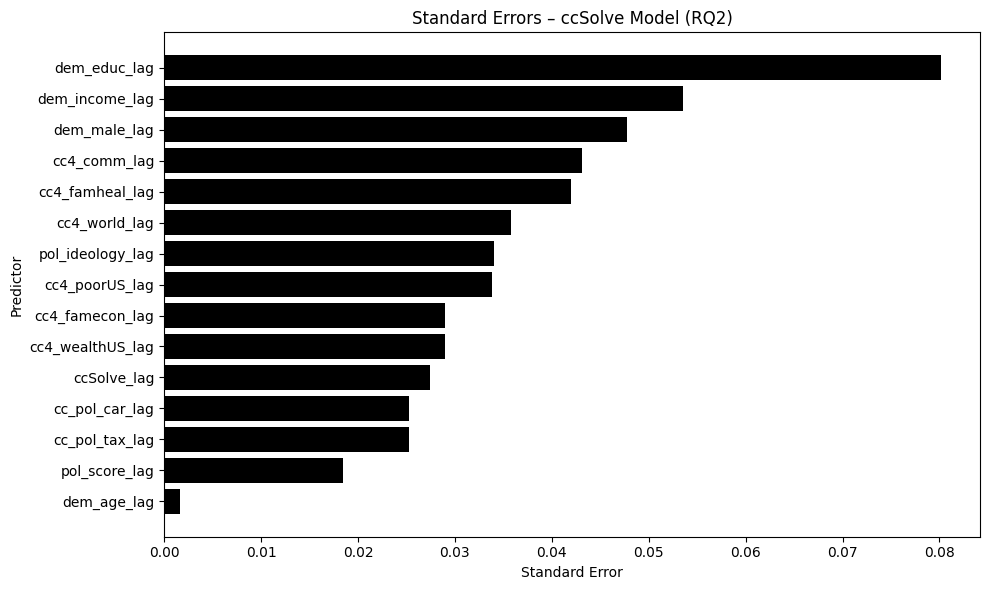

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Extract standard errors from RQ2 model
se_rq2 = pd.DataFrame({
    'Predictor': rq2_model.params.index,
    'Estimate': rq2_model.params.values,
    'StdError': rq2_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Optional: Print top 10 variables with largest SEs
print("Top variables with largest standard errors in RQ2 (ccSolve model):")
print(se_rq2.head(10).to_string(index=False))

# --- Step 2: Plot standard errors
plt.figure(figsize=(10, 6))
se_rq2_sorted = se_rq2.sort_values(by='StdError', ascending=True)
plt.barh(se_rq2_sorted['Predictor'], se_rq2_sorted['StdError'], color='black')
plt.title('Standard Errors – ccSolve Model (RQ2)')
plt.xlabel('Standard Error')
plt.ylabel('Predictor')
plt.tight_layout()
plt.savefig("../results/rq2_se_barplot_ccSolve.png", dpi=300)
plt.show()


* **Top 3 highest standard errors**:
  * `dem_educ_lag` (Education)
  * `dem_income_lag` (Income)
  * `dem_male_lag` (Gender)
* These three variables contribute **most to model uncertainty**, making their estimated effects less precise.
* This directly explains the **long confidence intervals** (whiskers) in the RQ2 dot-whisker plot — especially for `dem_educ_lag`, which had **the widest whisker** and was **not statistically significant**.
* Possible reasons for these large standard errors include:
  * **Multicollinearity**: Income and education are often correlated.
  * **Low variation** or **small sample sizes** within certain demographic subgroups.
  * **Inconsistent relationships** across waves, making it harder for the model to stabilize estimates.

---

### RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?
To explore this question, we extend the **Panel VAR(1)** framework by estimating a model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable. Our objective is to assess whether the impact of perceived climate harm on willingness to pay **varies by political ideology**.

We include **interaction terms between lagged harm perception variables and respondents’ ideological self-placement** (`pol_ideology`), allowing us to test whether the strength or direction of these relationships depends on political views. The model also controls for prior willingness to pay, support for climate policies, demographic characteristics

* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Political ideology**:
  `pol_ideology` (treated as a continuous or ordinal variable)
* **Interaction terms**:
  Each lagged harm variable is interacted with `pol_ideology`, e.g.,
  `cc4_world_lag × pol_ideology`, ..., `cc4_famecon_lag × pol_ideology`
* **Other controls** (lagged):
  * **Willingness to pay**: `ccSolve`
  * **Policy support**: `cc_pol_tax`, `cc_pol_car`
  * **Demographics**: `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The regression equation is estimated as:
$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \gamma \cdot \text{Ideology}_{t-1} 
+ \sum_{j=1}^{6} \delta_j \cdot (H_{j,t-1} \cdot \text{Ideology}_{t-1}) 
+ \sum_{k} \lambda_k \cdot Z_{k,t-1} 
+ \epsilon_t
$$

Where:
* $H_{j,t-1}$ are the lagged harm perception variables
* $\text{Ideology}_{t-1}$ is the lagged political ideology score
* $H_{j,t-1} \cdot I_k$ are the interaction terms between perceptions and ideology
* $Z_{l,t-1}$ are other controls (policy support, demographics)
* $\epsilon_t$ is the error term, clustered at the respondent level

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on complete responses across Waves 2–4.

By explicitly interacting political ideology with climate harm perceptions, this specification allows us to test whether **individuals with different ideological leanings respond differently to perceived climate risks** when forming their willingness to pay for solutions. This helps uncover conditional effects that would be masked in non-interactive models.

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variable groups
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
moderator = "pol_ideology"  # or use "pol_score" if you prefer
controls = ["ccSolve", "cc_pol_tax", "cc_pol_car", "dem_income", "dem_age", "dem_educ", "dem_male"]

# Sort by PID and WAVE
data = data.sort_values(by=["PID", "WAVE"])

# Create lagged versions
for var in harm_vars + controls + [moderator]:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# Create interaction terms between lagged harm perception and moderator
for harm in harm_vars:
    data[f"{harm}_x_{moderator}_lag"] = data.groupby("PID")[harm].shift(1) * data[moderator]

# Combine all predictors
lagged_vars = [f"{var}_lag" for var in harm_vars + controls + [moderator]]
interaction_terms = [f"{harm}_x_{moderator}_lag" for harm in harm_vars]
all_predictors = lagged_vars + interaction_terms

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["ccSolve"])

# Define outcome and predictors
X = panel_var_data[all_predictors]
y = panel_var_data["ccSolve"]
X = sm.add_constant(X)

# Fit model
rq3_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": panel_var_data["PID"]})

# Print summary
print(summary_col([rq3_model], stars=True, model_names=["ccSolve_t"],
                  info_dict={"N": lambda x: f"{int(x.nobs)}"}))


                                ccSolve_t
-----------------------------------------
const                           1.1803***
                                (0.1570) 
cc4_world_lag                   0.0811   
                                (0.1062) 
cc4_wealthUS_lag                0.0259   
                                (0.0862) 
cc4_poorUS_lag                  -0.0627  
                                (0.1025) 
cc4_comm_lag                    -0.0365  
                                (0.1405) 
cc4_famheal_lag                 0.0238   
                                (0.1440) 
cc4_famecon_lag                 0.0341   
                                (0.0953) 
ccSolve_lag                     0.0516*  
                                (0.0275) 
cc_pol_tax_lag                  0.1071***
                                (0.0254) 
cc_pol_car_lag                  -0.0296  
                                (0.0253) 
dem_income_lag                  0.0463   
                                (

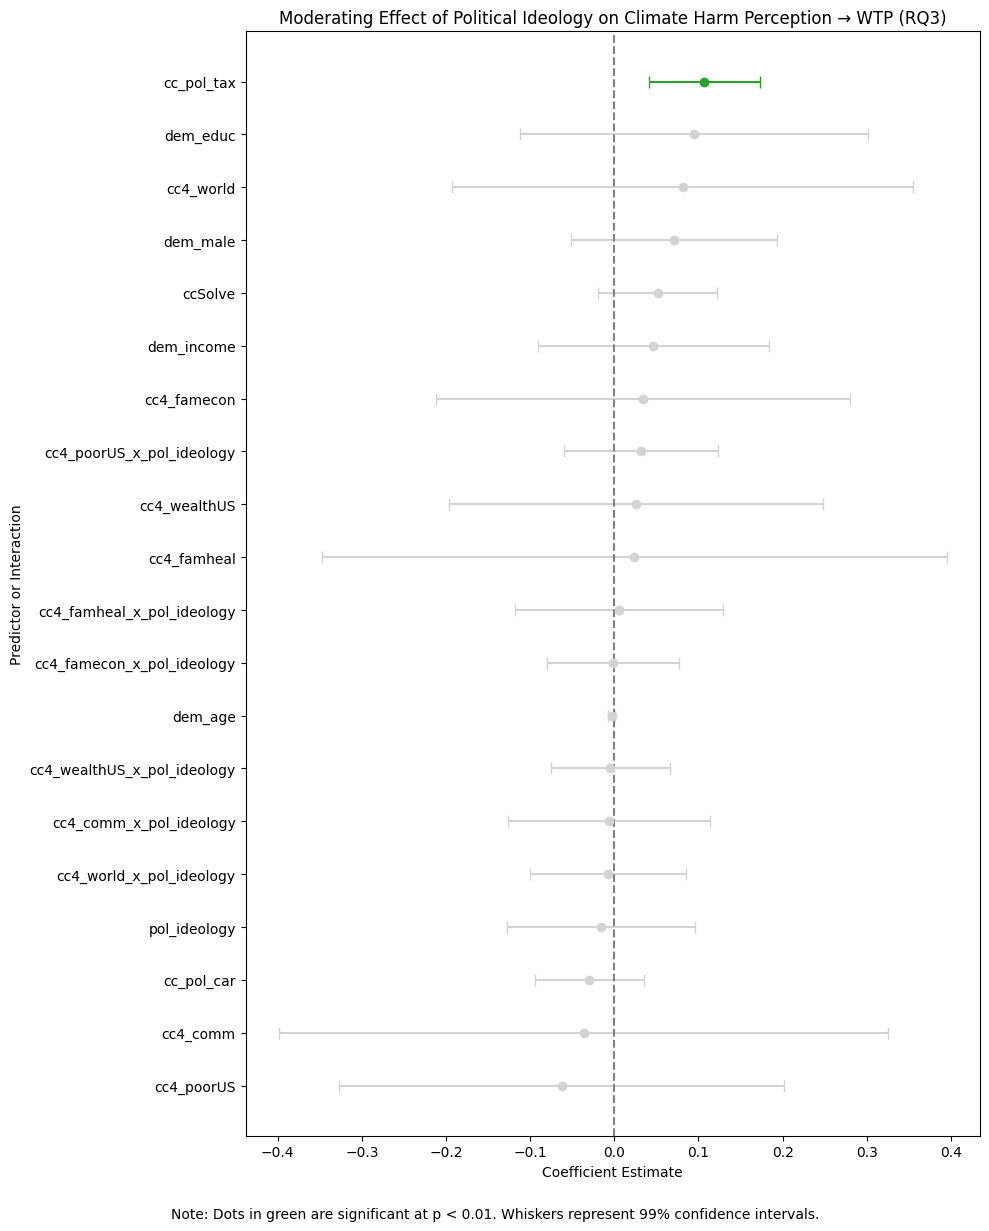

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function for RQ3 model
def extract_rq3_model_info(model):
    coefs = model.params

    # --- Updated: use 99% confidence intervals
    conf = model.conf_int(alpha=0.01)

    # --- Updated: extract p-values for p < 0.01 threshold
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")

    # --- Updated: significance based on p < 0.01
    df['significant'] = df['pval'] < 0.01

    # --- Original logic (for reference)
    # conf = model.conf_int()  # 95% CI by default
    # df['significant'] = ~((conf[0] <= 0) & (conf[1] >= 0))

    # Clean up names
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # interaction formatting
    return df.sort_values(by='coef', ascending=True)

# --- Extract model info
plot_df = extract_rq3_model_info(rq3_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("Moderating Effect of Political Ideology on Climate Harm Perception → WTP (RQ3)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction")

# --- Updated: note for 99% CI and p < 0.01 threshold
plt.figtext(
    0.5, -0.02,
    "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)

plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_moderation.png", dpi=300)
plt.show()

#### Interaction Model – RQ3
*RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?*

**Short answer: No, not meaningfully — at least not at a high threshold of significance.**

Among all the predictors and interaction terms in this model, the **only statistically significant predictor** (p < 0.01) is:
* **Prior support for a carbon tax (`cc_pol_tax`)**: People who previously supported carbon taxation are much more likely to express a willingness to pay for climate solutions.

None of the interaction terms — including, for example:
* `cc4_world × pol_ideology`
* `cc4_poorUS × pol_ideology`
* `cc4_comm × pol_ideology`

— were statistically significant at the **99% confidence level**. This means that **political ideology does not appear to significantly alter the effect of climate harm perceptions on willingness to pay**, at least in this dataset.

> **Long answer:** Willingness to pay for climate solutions appears to be **primarily driven by existing policy attitudes** (such as support for a carbon tax), and **not significantly shaped by ideology moderating the perception of harm**. People's views on who is harmed by climate change (e.g., the world, poor communities) do not interact with their political ideology in a way that meaningfully affects their willingness to contribute financially.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- VIF calculation ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop constant (optional)
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False))

                       Variable       VIF                                                                 Interpretation
    cc4_comm_x_pol_ideology_lag 87.388190 High multicollinearity (problematic, consider removing or combining variables)
 cc4_famheal_x_pol_ideology_lag 78.850529 High multicollinearity (problematic, consider removing or combining variables)
  cc4_poorUS_x_pol_ideology_lag 73.066330 High multicollinearity (problematic, consider removing or combining variables)
   cc4_world_x_pol_ideology_lag 66.679078 High multicollinearity (problematic, consider removing or combining variables)
                   cc4_comm_lag 47.984066 High multicollinearity (problematic, consider removing or combining variables)
                cc4_famheal_lag 43.391976 High multicollinearity (problematic, consider removing or combining variables)
cc4_wealthUS_x_pol_ideology_lag 38.330442 High multicollinearity (problematic, consider removing or combining variables)
 cc4_famecon_x_pol_ideology_lag 

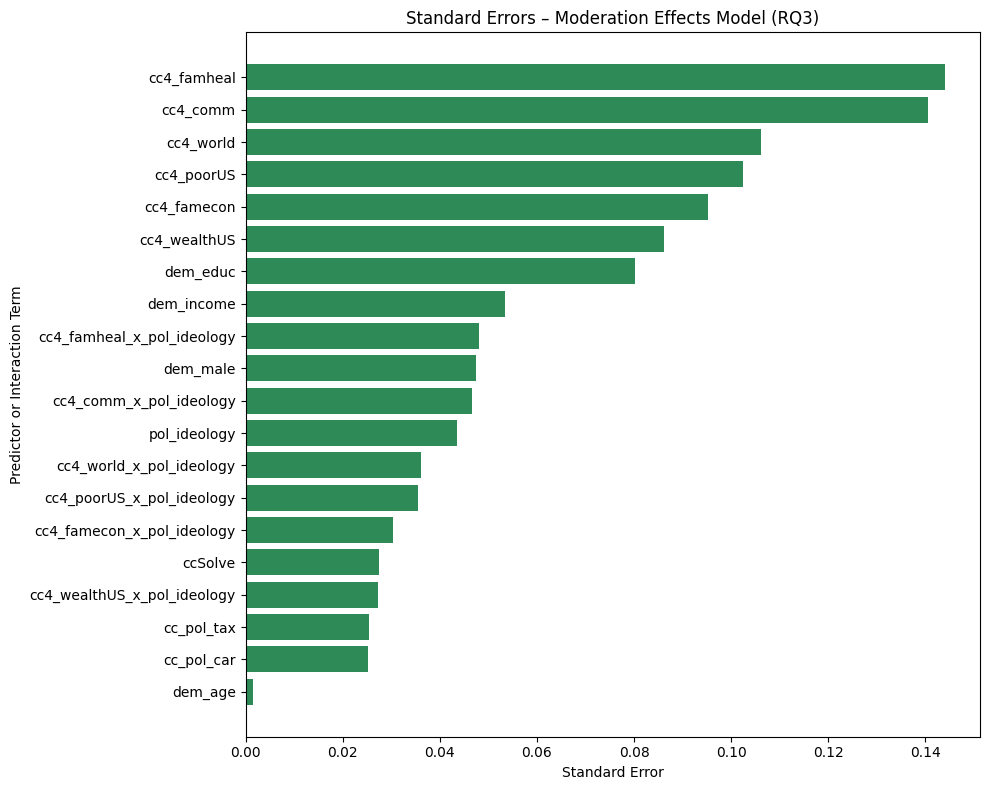

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract standard errors from RQ3 model
se_rq3 = pd.DataFrame({
    'Predictor': rq3_model.params.index,
    'Estimate': rq3_model.params.values,
    'StdError': rq3_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Step 2: Clean predictor labels
se_rq3['Predictor'] = se_rq3['Predictor'].str.replace('_lag', '', regex=False)
se_rq3['Predictor'] = se_rq3['Predictor'].str.replace(':', ' × ')

# --- Step 3: Plot
plt.figure(figsize=(10, 8))
se_rq3_sorted = se_rq3.sort_values(by='StdError', ascending=True)
plt.barh(se_rq3_sorted['Predictor'], se_rq3_sorted['StdError'], color='seagreen')
plt.title("Standard Errors – Moderation Effects Model (RQ3)")
plt.xlabel("Standard Error")
plt.ylabel("Predictor or Interaction Term")
plt.tight_layout()
plt.savefig("../results/rq3_se_barplot.png", dpi=300)
plt.show()

* **cc4\_famheal**, **cc4\_comm**, and **cc4\_world** (all lagged) have the **highest standard errors**.
    * These are also among the **main harm perception variables** — and all exhibit **long whiskers** in the dot-whisker plot (i.e., wide confidence intervals).
    * This signals that the model has **difficulty estimating their effects precisely**.
* VIFs for **interaction terms** (e.g., `cc4_comm × pol_ideology`) and their **parent harm variables** exceed **VIF = 40–80**, far above the conventional threshold of 10.
    * This inflates standard errors and makes it harder for the model to **separate out individual effects**, especially in interaction models.
* The **long whiskers** and **non-significance** of many key variables in the moderation model can be **attributed to multicollinearity**.
    * In particular, **harm perceptions are strongly correlated** with each other, and their interaction terms add redundancy.

To address the severe multicollinearity and inflated standard errors observed in the moderation model (RQ3), we will **combine collinear harm perception variables into a single index**. This approach retains the overall informational signal about climate harm while reducing redundancy and noise from overlapping predictors. By replacing six individual variables with one standardized `harm_index`, and interacting it with political ideology, we simplify the model structure, improve interpretability, and reduce the risk of unstable estimates due to multicollinearity. The resulting model offers a more focused lens through which to assess whether general perceptions of harm influence willingness to pay depending on political orientation.

In [13]:
import pandas as pd
import statsmodels.api as sm

# --- Load and sort data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
data = data.sort_values(by=["PID", "WAVE"])

# --- Define original harm perception variables ---
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
moderator = "pol_ideology"
controls = ["ccSolve", "cc_pol_tax", "cc_pol_car", "dem_income", "dem_age", "dem_educ", "dem_male"]

# --- Step 1: Create a harm index (mean of non-missing values across harm indicators) ---
data['harm_index'] = data[harm_vars].mean(axis=1)

# --- Step 2: Create lagged versions of the harm index, moderator, and control variables ---
lag_vars = ["harm_index", moderator] + controls
for var in lag_vars:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# --- Step 3: Create interaction term: harm_index × moderator ---
data[f"harm_index_x_{moderator}_lag"] = data[f"harm_index_lag"] * data[moderator]

# --- Step 4: Build model variables ---
predictors = [f"{var}_lag" for var in lag_vars] + [f"harm_index_x_{moderator}_lag"]
data_model = data.dropna(subset=predictors + ["ccSolve"])

X = data_model[predictors]
y = data_model["ccSolve"]
X = sm.add_constant(X)

# --- Step 5: Fit model ---
harm_index_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": data_model["PID"]})

# --- Step 6: Print summary ---
print(harm_index_model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     12.25
Date:                Wed, 28 May 2025   Prob (F-statistic):           5.13e-20
Time:                        11:46:59   Log-Likelihood:                -2350.0
No. Observations:                1722   AIC:                             4722.
Df Residuals:                    1711   BIC:                             4782.
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

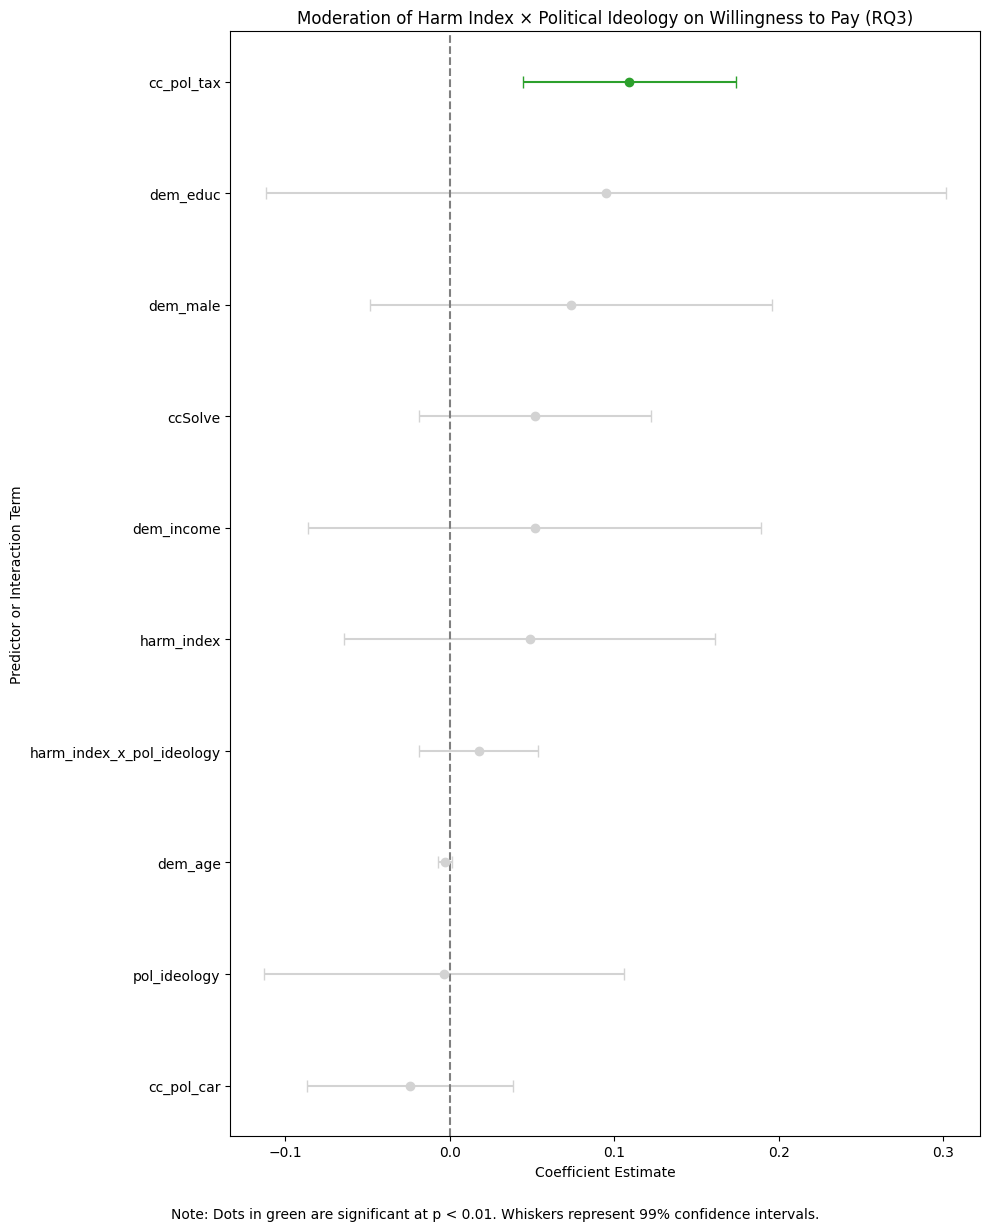

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Create results directory if not exists
os.makedirs("../results", exist_ok=True)

# --- Helper function for harm index model
def extract_model_info(model):
    coefs = model.params

    # Updated: use 99% confidence intervals
    conf = model.conf_int(alpha=0.01)

    # Updated: extract p-values for p < 0.01 threshold
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")

    # Updated: significance flag based on p < 0.01
    df['significant'] = df['pval'] < 0.01

    # Optional cleanup for display
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # for interactions

    return df.sort_values(by='coef', ascending=True)

# --- Extract plot data
plot_df = extract_model_info(harm_index_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("Moderation of Harm Index × Political Ideology on Willingness to Pay (RQ3)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction Term")

# Add note
plt.figtext(
    0.5, -0.02,
    "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)

plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_harm_index_model.png", dpi=300)
plt.show()

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Make a copy of the design matrix used to fit the model
X_vif = X.copy()

# Calculate VIF
vif_df = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Interpretation logic
def interpret_vif(value):
    if value >= 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif value >= 5:
        return "Moderate multicollinearity (monitor closely)"
    elif value >= 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_df["Interpretation"] = vif_df["VIF"].apply(interpret_vif)

# Remove intercept if present
vif_df = vif_df[vif_df["Variable"] != "const"]

# Format for clean output
vif_df["VIF"] = vif_df["VIF"].map("{:,.3f}".format)

# Sort and print nicely
print(vif_df.sort_values(by="VIF", ascending=False).to_string(index=False))

                     Variable   VIF                                             Interpretation
harm_index_x_pol_ideology_lag 8.638               Moderate multicollinearity (monitor closely)
               harm_index_lag 4.799 Some correlation (acceptable, but check related variables)
             pol_ideology_lag 3.663 Some correlation (acceptable, but check related variables)
               cc_pol_tax_lag 2.131 Some correlation (acceptable, but check related variables)
               cc_pol_car_lag 2.043 Some correlation (acceptable, but check related variables)
               dem_income_lag 1.141            Low correlation (no multicollinearity concerns)
                 dem_educ_lag 1.134            Low correlation (no multicollinearity concerns)
                  ccSolve_lag 1.068            Low correlation (no multicollinearity concerns)
                 dem_male_lag 1.052            Low correlation (no multicollinearity concerns)
                  dem_age_lag 1.038            Low

* The **highest VIF (8.638)** is below the typical "problematic" threshold of **10**, so the model is *not in critical danger*, but:
* The interaction term does have **moderate collinearity**, which is **expected** in interaction-heavy models.
* Compared to the **original full-interaction model**, this one has **dramatically improved multicollinearity**, especially since all VIFs are now below 10.

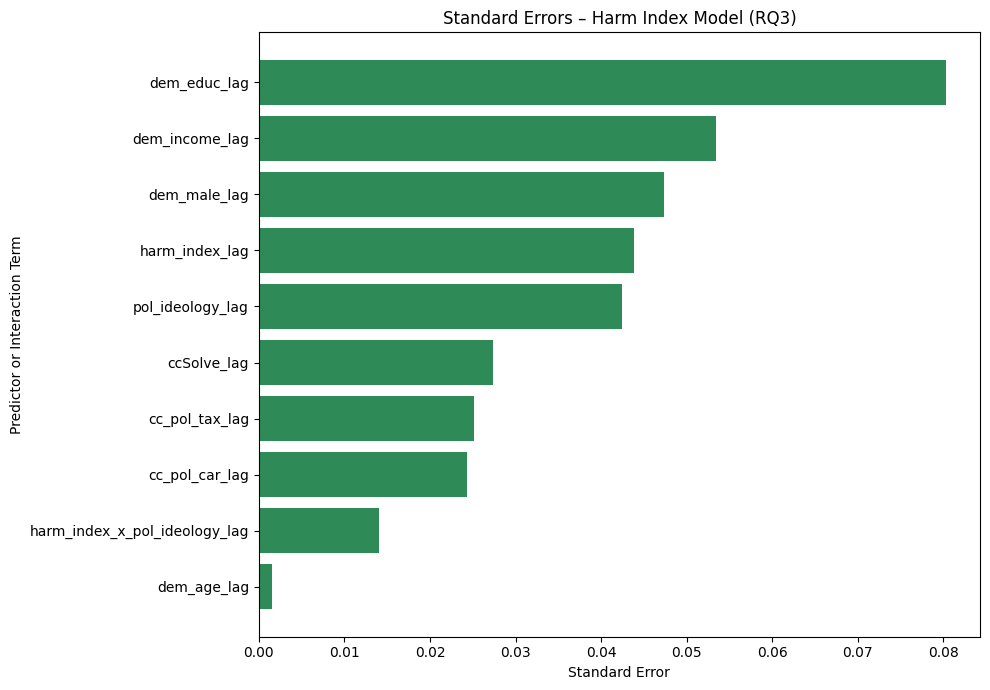

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract standard errors from the model ---
se_harm_index = pd.DataFrame({
    'Predictor': harm_index_model.params.index,
    'Estimate': harm_index_model.params.values,
    'StdError': harm_index_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Step 2: Plot standard errors ---
plt.figure(figsize=(10, 7))
se_sorted = se_harm_index.sort_values(by='StdError', ascending=True)
plt.barh(se_sorted['Predictor'], se_sorted['StdError'], color='seagreen')
plt.title('Standard Errors – Harm Index Model (RQ3)')
plt.xlabel('Standard Error')
plt.ylabel('Predictor or Interaction Term')
plt.tight_layout()
plt.savefig("../results/rq3_se_barplot_harm_index.png", dpi=300)
plt.show()

The plot above shows the standard errors for predictors in the **harm index version of the RQ3 moderation model**. Notably, the three demographic variables — **education**, **income**, and **gender** — again exhibit the **highest standard errors**, indicating considerable uncertainty in estimating their effects. In contrast, the composite **harm index** and its interaction with political ideology show more stable estimates, with the interaction term having one of the smallest standard errors. This supports the decision to simplify the model: the harm index preserves interpretive clarity while reducing multicollinearity and estimation noise from the full interaction setup.

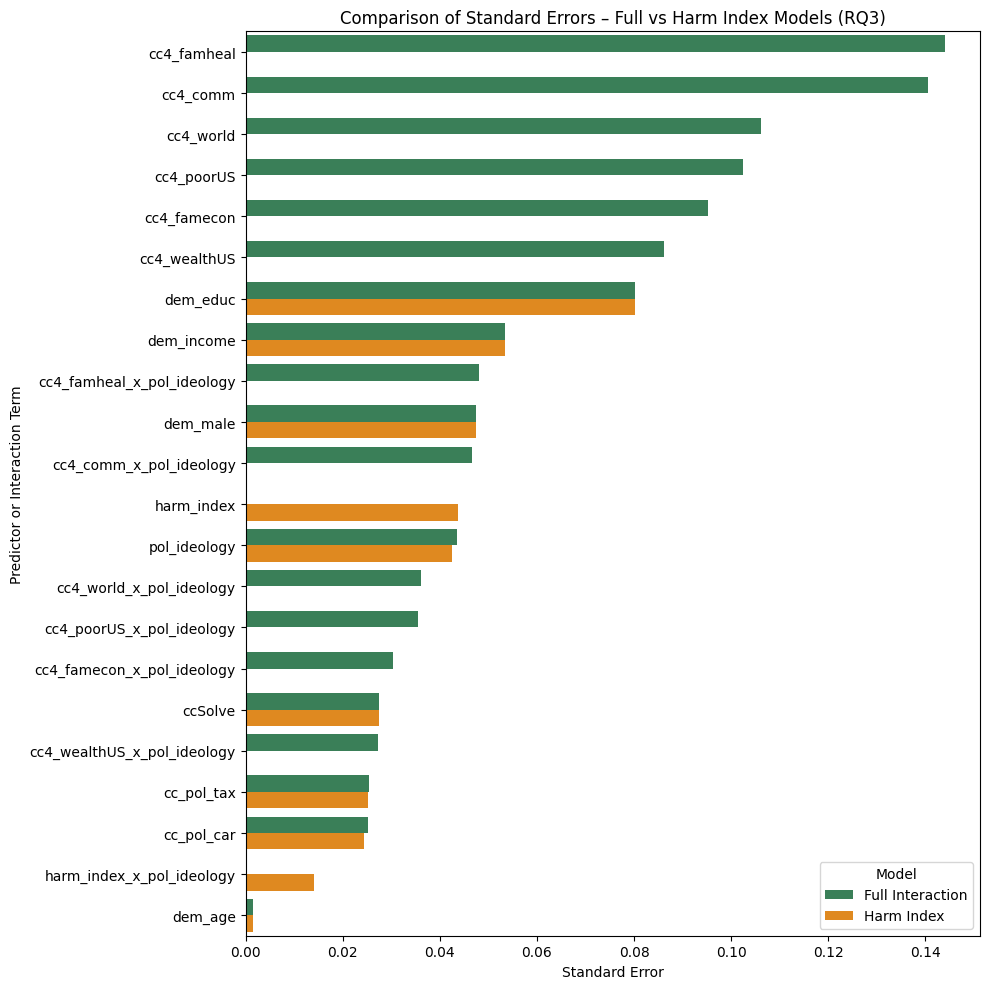

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Extract SEs from full interaction model (rq3_model) ---
se_rq3_full = pd.DataFrame({
    'Predictor': rq3_model.params.index,
    'Estimate': rq3_model.params.values,
    'StdError': rq3_model.bse.values
}).query("Predictor != 'const'")
se_rq3_full['Model'] = 'Full Interaction'

# Clean labels
se_rq3_full['Predictor'] = se_rq3_full['Predictor'].str.replace('_lag', '', regex=False)
se_rq3_full['Predictor'] = se_rq3_full['Predictor'].str.replace(':', ' × ')

# --- Extract SEs from harm index model (harm_index_model) ---
se_rq3_index = pd.DataFrame({
    'Predictor': harm_index_model.params.index,
    'Estimate': harm_index_model.params.values,
    'StdError': harm_index_model.bse.values
}).query("Predictor != 'const'")
se_rq3_index['Model'] = 'Harm Index'

# Clean labels
se_rq3_index['Predictor'] = se_rq3_index['Predictor'].str.replace('_lag', '', regex=False)

# --- Combine both ---
combined_se = pd.concat([se_rq3_full, se_rq3_index], ignore_index=True)

# --- Plot ---
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(
    data=combined_se.sort_values(by='StdError', ascending=False),
    y='Predictor', x='StdError', hue='Model', palette=['seagreen', 'darkorange']
)
plt.title("Comparison of Standard Errors – Full vs Harm Index Models (RQ3)")
plt.xlabel("Standard Error")
plt.ylabel("Predictor or Interaction Term")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("../results/rq3_se_comparison_barplot.png", dpi=300)
plt.show()

This side-by-side bar chart compares the **standard errors** from the **full interaction model** and the **harm index model** for RQ3. The chart reveals a clear pattern: the harm index model (orange bars) consistently reduces standard errors for most variables, especially for interaction terms. In the full model, the original harm perception variables (e.g., `cc4_famheal`, `cc4_comm`) and their interactions exhibit very large standard errors—often above 0.10—reflecting high estimation uncertainty likely caused by multicollinearity. By contrast, combining these into a single harm index substantially compresses the uncertainty, especially for the interaction with political ideology. This visualization strongly supports the model simplification step, confirming that the harm index version is more statistically stable and interpretable.

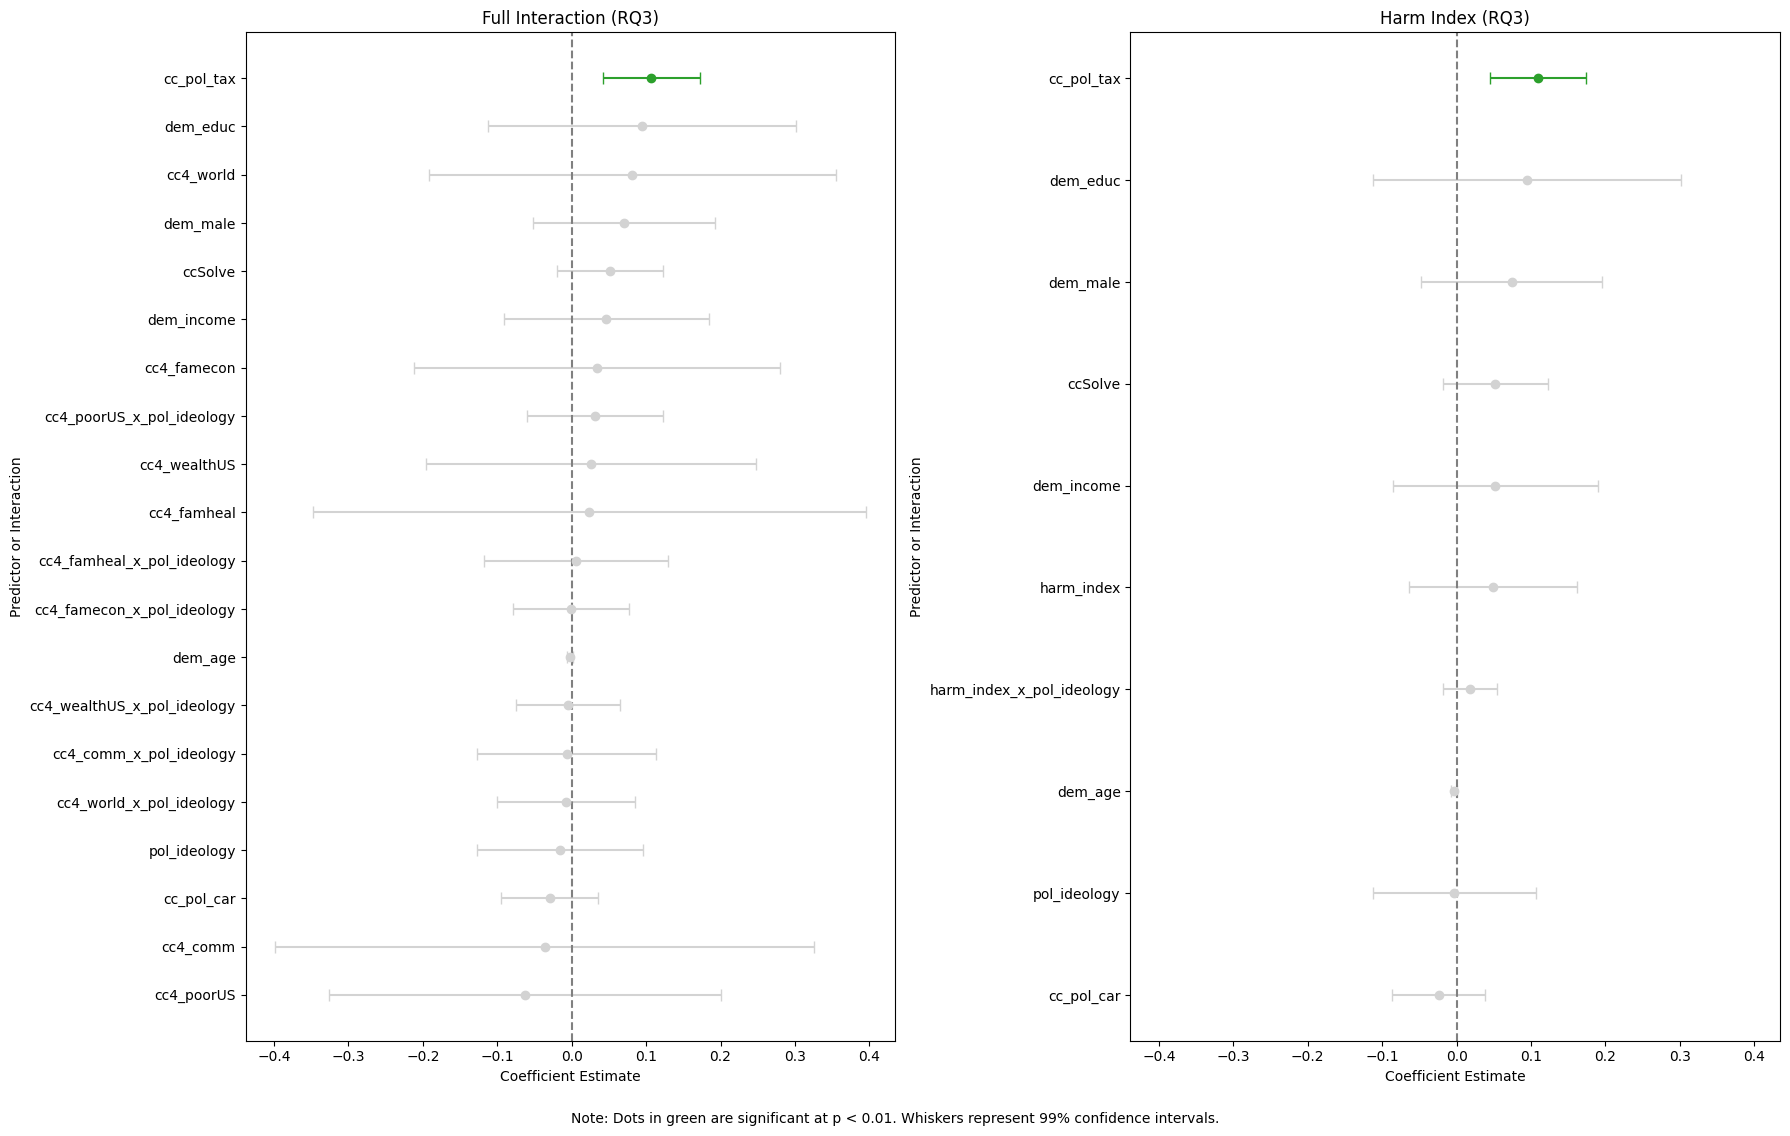

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("../results", exist_ok=True)

# --- Combine model results for comparison ---
# Extract model info for both models
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values,
        'model': label
    }).query("predictor != 'const'")

    df['significant'] = df['pval'] < 0.01
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')
    return df

df_full = extract_model_info(rq3_model, "Full Interaction (RQ3)")
df_index = extract_model_info(harm_index_model, "Harm Index (RQ3)")
combined_df = pd.concat([df_full, df_index])

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(18, 12), sharex=True)

for ax, (model_name, df) in zip(axs, combined_df.groupby("model")):
    df_sorted = df.sort_values("coef")
    for _, row in df_sorted.iterrows():
        color = 'tab:green' if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=color,
            ecolor=color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(model_name)
    ax.set_xlabel("Coefficient Estimate")
    ax.set_ylabel("Predictor or Interaction")

fig.text(0.5, 0.01,
         "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
         ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../results/rq3_comparison_dot_whisker.png", dpi=300)
plt.show()

This side-by-side comparison of the **full interaction model** and the **harm index model** shows the benefits of reducing complexity through variable combination. In the **left panel**, the full model includes multiple separate harm variables and their interactions with political ideology. Although this approach retains nuance, it suffers from long confidence intervals (wide whiskers) and no statistically significant interaction effects.

In contrast, the **right panel** condenses harm perceptions into a single `harm_index` and interacts it with political ideology. This simplified model shows a cleaner structure with more stable estimates and dramatically reduced uncertainty. While the interaction term (`harm_index × pol_ideology`) is not significant, the model still retains the significant effect of `cc_pol_tax`, suggesting the streamlined specification helps isolate clearer effects without losing interpretability.

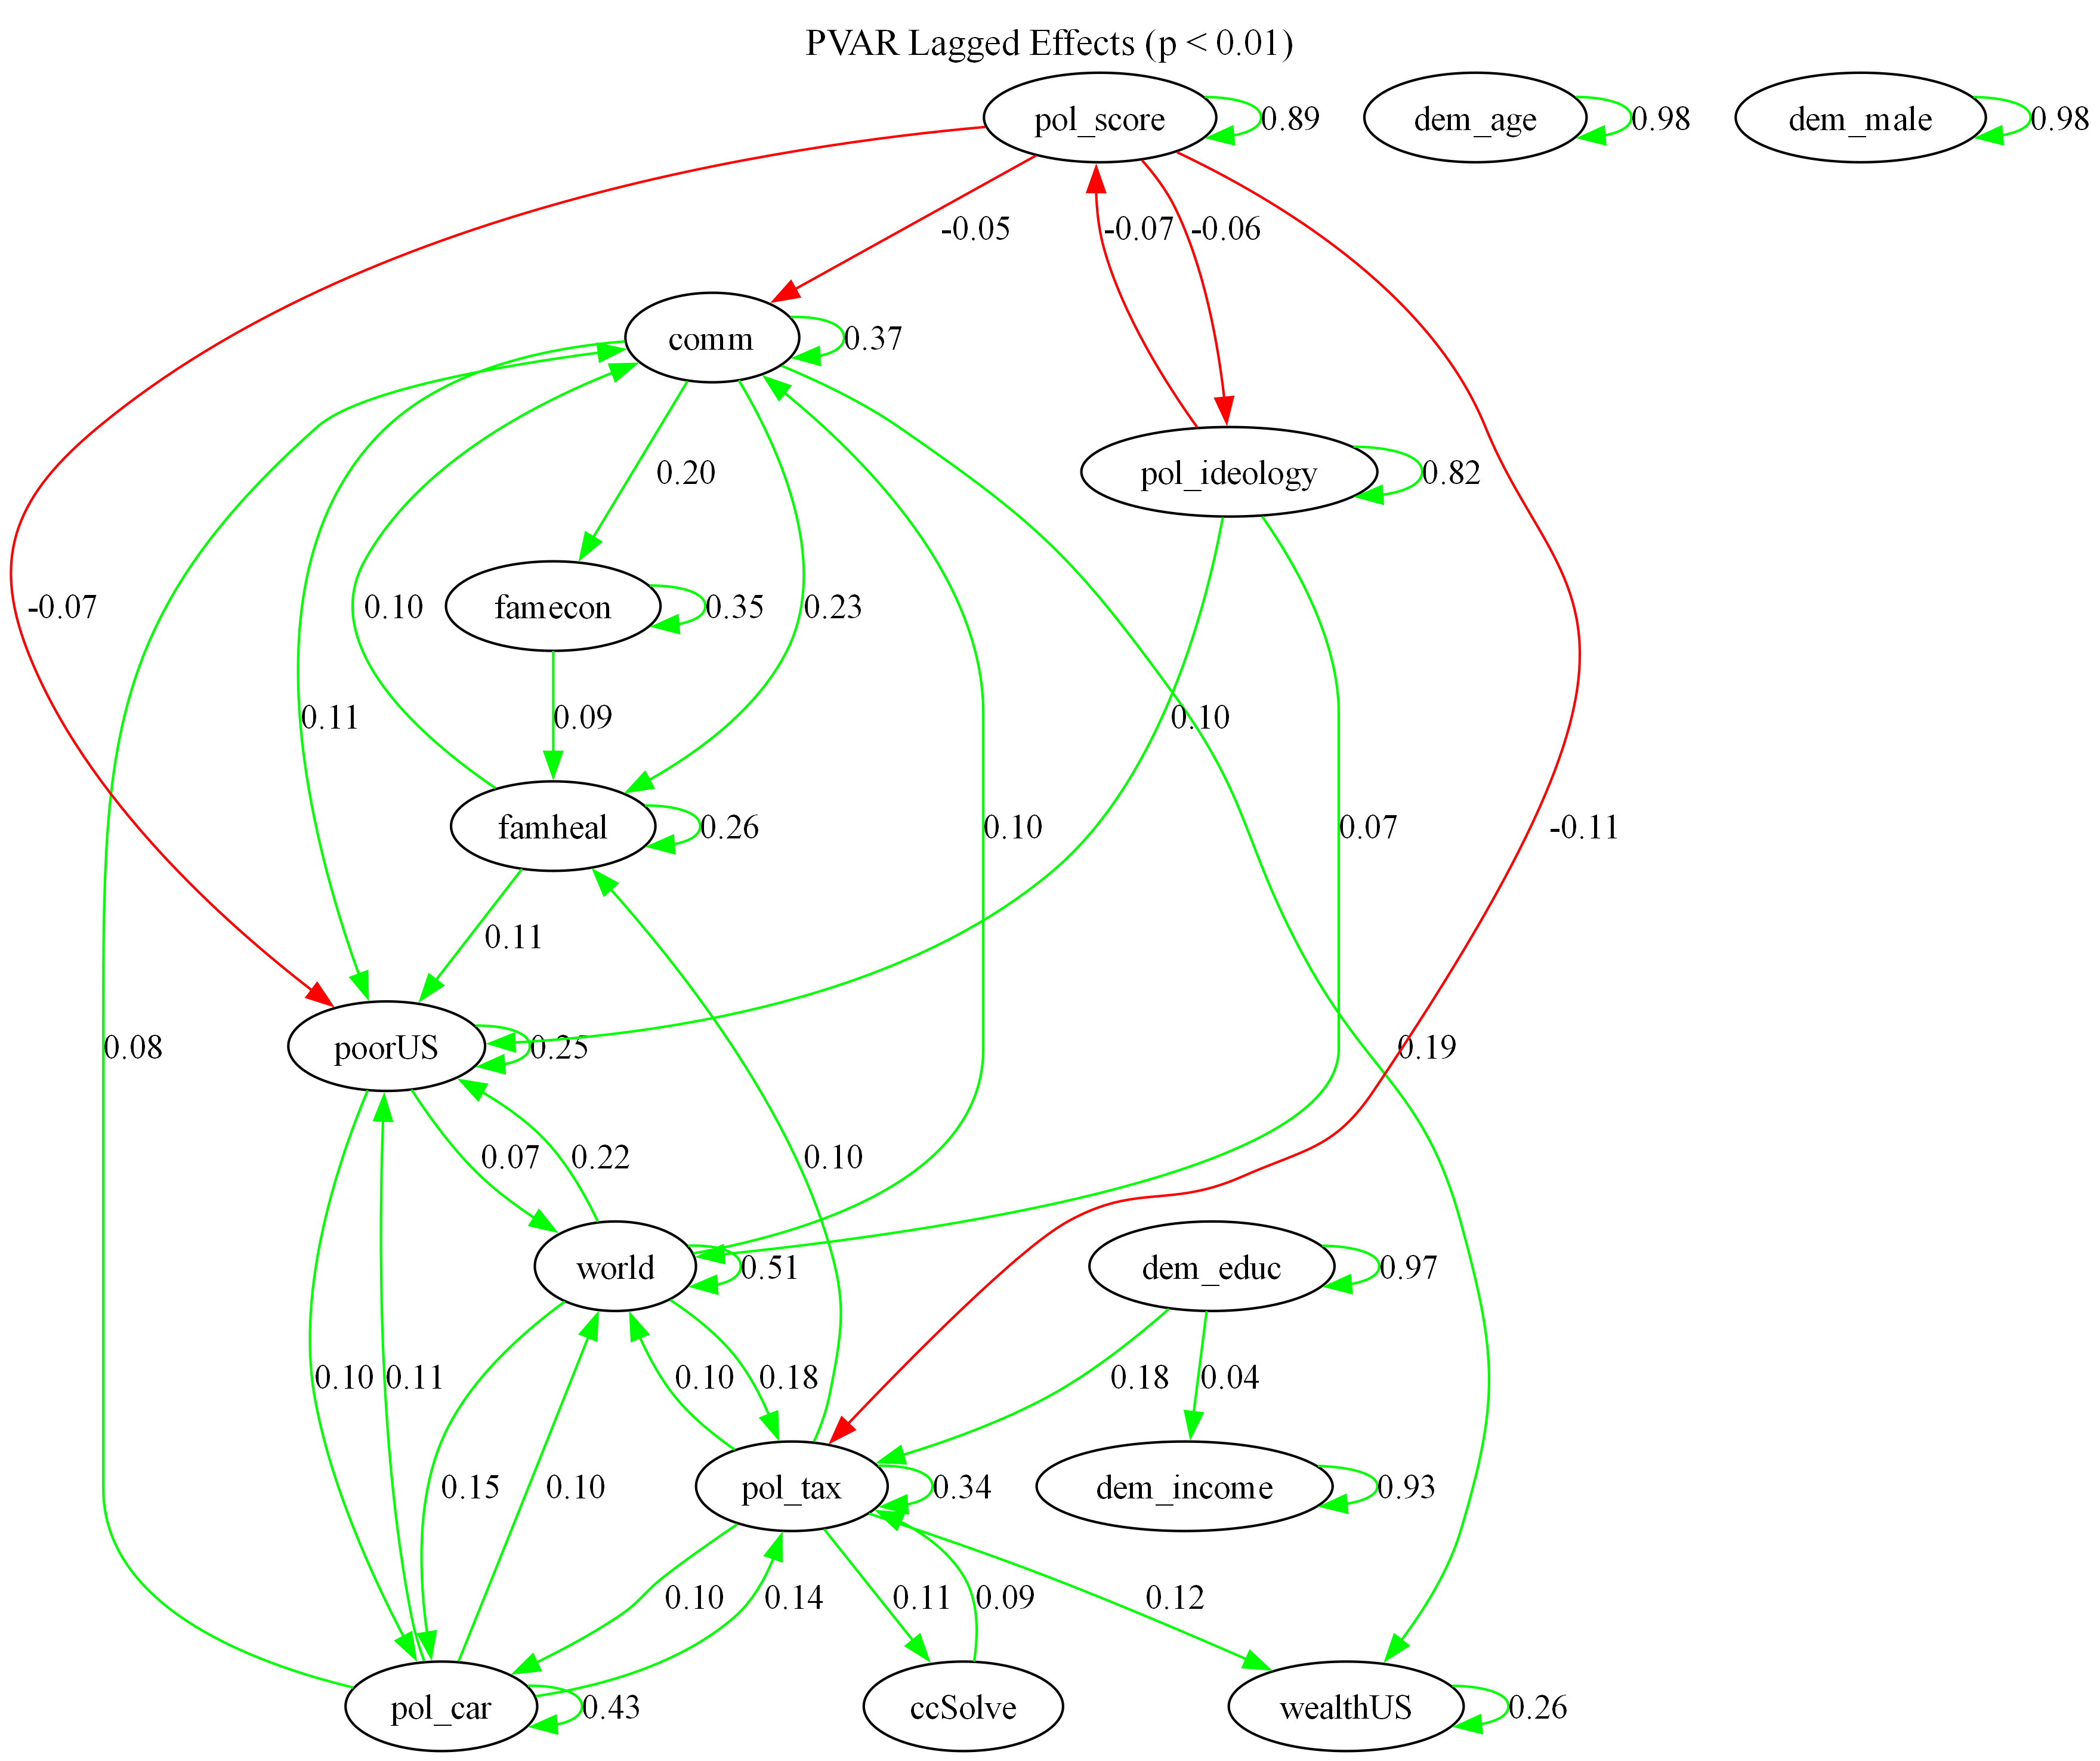

In [19]:
import os
import pandas as pd
import statsmodels.api as sm
import networkx as nx
from graphviz import Digraph
from IPython.display import Image, display

# Optional: Add path to Graphviz binaries if needed
# os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

# --- Load data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# --- Define predictors ---
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Preprocess ---
data = data.sort_values(by=['PID', 'WAVE'])
for var in continuous_predictors:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

X_vars = [f"{var}_lag" for var in continuous_predictors]
Y_vars = continuous_predictors
df = data.dropna(subset=X_vars + Y_vars)

# --- Build edge list based on lagged regression ---
edges = []
for y in Y_vars:
    X = df[X_vars]
    X = sm.add_constant(X)
    y_vals = df[y]
    model = sm.OLS(y_vals, X).fit()

    for predictor, pval in model.pvalues.items():
        if predictor == 'const' or predictor not in X.columns:
            continue
        
        # --- Previous threshold: p < 0.05
        # if pval < 0.05:

        # --- New threshold: p < 0.01
        if pval < 0.01:
            weight = model.params[predictor]
            source = predictor.replace("_lag", "")
            target = y
            edges.append((source, target, weight))

# --- Build Graphviz Digraph ---
dot = Digraph(engine="dot")
dot.attr(dpi='300', fontsize='14', rankdir='TB')
dot.attr(label='PVAR Lagged Effects (p < 0.01)', labelloc='t', fontsize='15')

# --- Add nodes
nodes = set()
for src, tgt, _ in edges:
    nodes.update([src, tgt])

for node in sorted(nodes):
    label = node.replace("cc4_", "").replace("cc_", "")
    dot.node(node, label=label)

# --- Add edges
for src, tgt, weight in edges:
    color = "green" if weight > 0 else "red"
    dot.edge(src, tgt, label=f"{weight:.2f}", color=color)

# --- Render and save PNG only (no viewer, no .gv file)
output_path = "../results/pvar_graphviz"
dot.render(output_path, format="png", cleanup=True)

# --- Display the PNG below the cell
display(Image(filename=f"{output_path}.png"))

In [20]:
import pandas as pd
import numpy as np

# --- Load data ---
df = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
print("Variable types:\n", df[variables].dtypes)
print("\n Sample values:\n", df[variables].head())

# --- Define your analysis variables ---
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Sort by PID and WAVE ---
df = df.sort_values(['PID', 'WAVE'])

# --- Ensure all PIDs have the same number of timepoints ---
obs_per_pid = df.groupby('PID').size()
print("Unique observation counts per PID:\n", obs_per_pid.value_counts())

# Filter only PIDs with exactly 3 timepoints
valid_pids = obs_per_pid[obs_per_pid == 3].index
df = df[df['PID'].isin(valid_pids)]
print(f"Using {len(valid_pids)} PIDs with 3 timepoints each.")

# --- Construct panel array (T, N, C) ---
panel_data = []
units = df['PID'].unique()

for pid in units:
    sub_df = df[df['PID'] == pid].sort_values('WAVE')
    if sub_df.shape[0] < 3:
        continue
    panel_data.append(sub_df[variables].values)

# Convert to panel array: T x N x C
panel_array = np.stack(panel_data, axis=-1)
print("Shape of panel_array (T, N, C):", panel_array.shape)

# --- Check for NaNs and Infs ---
print("NaNs in panel_array:", np.isnan(panel_array).sum())
print("Infs in panel_array:", np.isinf(panel_array).sum())

T, N, C = panel_array.shape
reshaped = panel_array.transpose(1, 0, 2).reshape(N, T * C)  # shape: (N, T*C)
flat_stds = np.std(reshaped, axis=1)

# Drop variables with zero overall variance
non_constant_indices = [i for i, std in enumerate(flat_stds) if std > 0]
panel_array = panel_array[:, non_constant_indices, :]
variables = [variables[i] for i in non_constant_indices]

print("Dropped variables with no variance across the full panel.")
print("New panel_array shape:", panel_array.shape)
print("Variables retained:", variables)

Variable types:
 cc4_world       float64
cc4_wealthUS    float64
cc4_poorUS      float64
cc4_comm        float64
cc4_famheal     float64
cc4_famecon     float64
ccSolve           int64
cc_pol_tax      float64
cc_pol_car      float64
dem_income        int64
dem_age           int64
dem_educ          int64
dem_male          int64
pol_score         int64
pol_ideology      int64
dtype: object

 Sample values:
    cc4_world  cc4_wealthUS  cc4_poorUS  cc4_comm  cc4_famheal  cc4_famecon  \
0       3.67          1.00        3.67      3.67         3.67         2.33   
1       5.00          3.67        5.00      3.67         3.67         2.33   
2       3.67          2.33        2.33      2.33         2.33         2.33   
3       3.67          3.67        5.00      2.33         2.33         2.33   
4       5.00          3.67        5.00      2.33         2.33         1.00   

   ccSolve  cc_pol_tax  cc_pol_car  dem_income  dem_age  dem_educ  dem_male  \
0        2         4.0         4.0         

In [21]:
import numpy as np
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# Assuming panel_array has shape (T, N, C)
T, N, C = panel_array.shape

# Reshape panel_array to (T*C, N)
reshaped_data = panel_array.transpose(2, 0, 1).reshape(T * C, N)

# Create Tigramite DataFrame
dataframe = DataFrame(data=reshaped_data, var_names=variables)

# Set up PCMCI with partial correlation test
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance='analytic'))

# Run PCMCI with tau_max = 1 (1 lag)
results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)

# Print significant links at alpha = 0.01
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                              val_matrix=results['val_matrix'],
                              alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable cc4_world has 16 link(s):
        (cc4_poorUS  0): pval = 0.00000 | val =  0.756
        (cc4_comm  0): pval = 0.00000 | val =  0.674
        (cc4_wealthUS  0): pval = 0.00000 | val =  0.580
        (cc4_famheal  0): pval = 0.00000 | val =  0.580
        (cc_pol_car  0): pval = 0.00000 | val =  0.486
        (cc_pol_tax  0): pval = 0.00000 | val =  0.475
        (cc4_famecon  0): pval = 0.00000 | val =  0.398
        (pol_score  0): pval = 0.00000 | val = -0.364
        (pol_ideology  0): pval = 0.00000 | val =  0.361
        (cc4_world -1): pval = 0.00000 | val =  0.334
        (ccSolve  0): pval = 0.00000 | val =  0.147
        (pol_score -1): pval = 0.00000 | val = -0.098
        (cc_pol_tax -1): pval = 0.00001 | val =  0.089
        (cc4_comm -1): pval = 0.00006 | val =  0.079
        (cc4_famheal -1): pval = 0.00086 | val =  0.066
        (dem_age  0): pval = 0.00286 | val = -0.059

    Variable cc4_wealthUS has 14 link(s):
    

In [22]:
# Configuration
tau_max = 1  # maximum time lag to test
pc_alpha = 0.01  # significance level for PC-stable algorithm
pcmci.verbosity = 1 # verbosity: 0 (silent), 1 (basic), 2 (detailed)

# Run PCMCI+
results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable cc4_world has 3 link(s):
        (cc4_world -1): max_pval = 0.00000, |min_val| =  0.245
        (cc_pol_tax -1): max_pval = 0.00000, |min_val| =  0.092
        (pol_score -1): max_pval = 0.00010, |min_val| =  0.077

    Variable cc4_wealthUS has 4 link(s):
        (cc4_wealthUS -1): max_pval = 0.00000, |min_val| =  0.126
        (cc4_comm -1): max_pval = 0.00000, |min_val| =  0.125
        (cc_pol_tax -1): max_pval = 0.00036, |min_val| =  0.070
        (pol_score -1): max_pval = 0.00331, |min_val| =  0.058

    Variable cc4_poorUS has 4 link(s):
        (cc4_poorUS -1): max_pval = 0.00000, |min_val| =  0.096
        (cc4_world -1): max_pval = 0.00001, |min_val| =  0.089
        (pol_score -1): max_pval = 0.00023, |min_val| =  0.072
        (cc

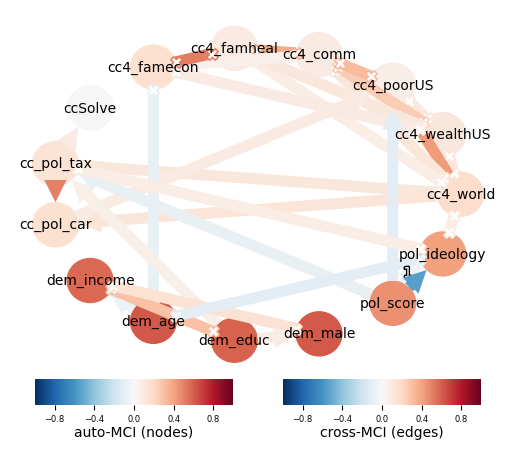

In [23]:
from tigramite import plotting as tp
import matplotlib.pyplot as plt

# Unpack the figure and axes
fig, ax = tp.plot_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=variables,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)'
)

# Save the figure
fig.savefig("../results/pcmci_graph.png", dpi=300, bbox_inches='tight')